## DATA SCIENCE / SECTION 1 / Project


## 1. Data Cleaning

- 지역에 따라서 선호하는 게임 장르가 다를까
- 연도별 게임의 트렌드가 있을까
- 출고량이 높은 게임에 대한 분석

와 같은 분석하고자 하는 주제에 맞추어 Data의 column별 결측치, 이상치를 제거합니다.

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')
import scipy.stats as stats
import math
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
#@title
df_raw = pd.read_csv('/content/drive/MyDrive/bootcamp_project/vgames2.csv')
df_raw = df_raw.drop('Unnamed: 0', axis=1)

In [ ]:
#@title
df_raw.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [ ]:
#@title
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


### 1_1 Sales_data Handling

- 게임의 판매량 기본단위 = Million(10^6)
 - 'M'이 포함되어 있는 데이터 정제('M'제거)
 - 'K'가 포함되어 있는 데이터 정제('K'제거)


In [ ]:
# sale데이터 슬라이싱
df = df_raw.iloc[:,:-4]
df_Sale = df_raw.iloc[:,-4:]
print(df_Sale.iloc[10])
df_Sale.head()

NA_Sales        480K
EU_Sales       0.33M
JP_Sales          0K
Other_Sales     0.06
Name: 10, dtype: object


,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,0.04,0,0,0
1,0.17,0,0,0.01
2,0,0,0.02,0
3,0.04,0,0,0
4,0.12,0.09,0,0.04


In [ ]:
# 일반적으로 게임 판매량은 million단위이기 때문에,'K'단위의 경우 10^-3을 해주는게 맞으나,
# 10K는 100억판매량이기에 불가능하며, 0.01K의 경우 천만판매량이라는 수량은 가능하기 때문에 0K<x<1K값이 있는지 확인

list1 = [val for col in df_Sale for val in df_Sale[col]]
list1 = filter(lambda val: isinstance(val, str) and val[-1].lower() == 'k', list1)
list1 = map(lambda val: float(val[:-1]), list1)
list1 = list(filter(lambda val: 0<val<1, list1))
list1 # 없음

[]

In [ ]:
# M이 들어간값은 M을 제외하고 float으로 바꾸며,
# K가 들어간값은 K를 제외하고 1000으로 나눠 단위를 통일해주는 함수
def del_M_K(val):
  if type(val)!=str:
    return val
  elif val[-1]=='M':
    return float(val[:-1])
  elif val[-1]=='K':
    return float(val[:-1])/1000
  else:
    return float(val)

In [ ]:
for col in df_Sale:
  df_Sale[col] = df_Sale[col].apply(del_M_K)

In [ ]:
print(df_Sale.iloc[10])
df_Sale.dtypes

NA_Sales       0.48
EU_Sales       0.33
JP_Sales       0.00
Other_Sales    0.06
Name: 10, dtype: float64


NA_Sales       float64
EU_Sales       float64
JP_Sales       float64
Other_Sales    float64
dtype: object

In [ ]:
# Sales 전체합산 column 추가
df_Sale['Tot_Sales'] = (df_Sale.NA_Sales)+(df_Sale.EU_Sales)+(df_Sale.JP_Sales)+(df_Sale.Other_Sales)

In [ ]:
df_Sale

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales
0,0.04,0.00,0.00,0.00,0.04
1,0.17,0.00,0.00,0.01,0.18
2,0.00,0.00,0.02,0.00,0.02
3,0.04,0.00,0.00,0.00,0.04
4,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...
16593,0.15,0.04,0.00,0.01,0.20
16594,0.01,0.00,0.00,0.00,0.01
16595,0.44,0.19,0.03,0.13,0.79
16596,0.05,0.05,0.25,0.03,0.38


In [ ]:
#data 합치기
df = pd.concat([df, df_Sale], axis=1)
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


### 1_2 Year_data Handling.Ver1

- Tot_Sales가 평균 이상인 데이터는 분석에 영향을 미칠것이라 예상
 - Tot_Sales가 평균미만이며, Year가 null값인 경우 drop



In [ ]:
print(df.loc[(df.Tot_Sales < df.Tot_Sales.mean()) & (df.Year.isnull())].shape[0]) #Tot_Sales가 평균미만이며, Year가 null값인 경우
print(df.loc[(df.Tot_Sales >= df.Tot_Sales.mean()) & (df.Year.isnull())].shape[0]) #Tot_Sales가 평균이상이며, Year가 null값인 경우

221
50


In [ ]:
df2 = df.loc[((df.Tot_Sales >= df.Tot_Sales.mean()) & (df.Year.isnull())) | (df.Year.notnull())]
df = df2
df.shape # 16598개의 열에서 전체 판매량이 평균미만이며 Year가 null인 221개의 열이 제외됨을 확인 / 현재 열 : 16377

(16377, 10)

### 1_3 Genre_data Handling.Ver1

- Tot_Sales가 평균 이상인 데이터는 분석에 영향을 미칠것이라 예상
 - Tot_Sales가 평균미만이며, Genre가 null값인 경우 drop

In [ ]:
print(df.loc[(df.Tot_Sales < df.Tot_Sales.mean()) & (df.Genre.isnull())].shape[0]) #Tot_Sales가 평균미만이며, Genre가 null값인 경우
print(df.loc[(df.Tot_Sales >= df.Tot_Sales.mean()) & (df.Genre.isnull())].shape[0]) #Tot_Sales가 평균이상이며, Genre가 null값인 경우

33
17


In [ ]:
df = df.loc[((df.Tot_Sales >= df.Tot_Sales.mean()) & (df.Genre.isnull())) | (df.Genre.notnull())]
df.shape # 16377개의 열에서 전체 판매량이 평균미만이며 Genre가 null인 33개의 열이 제외됨을 확인 / 현재 열 : 16344

(16344, 10)

### 1_4 Publisher_data Handling.Ver1

- Tot_Sales가 평균 이상인 데이터는 판별에 영향을 미칠것이라 예상
 - Tot_Sales가 평균미만이며, Publisher가 null값인 경우 drop

In [ ]:
print(df.loc[(df.Tot_Sales < df.Tot_Sales.mean()) & (df.Publisher.isnull())].shape[0]) #Tot_Sales가 평균미만이며, Publisher가 null값인 경우
print(df.loc[(df.Tot_Sales >= df.Tot_Sales.mean()) & (df.Publisher.isnull())].shape[0]) #Tot_Sales가 평균이상이며, Publisher가 null값인 경우

32
6


In [ ]:
df = df.loc[((df.Tot_Sales >= df.Tot_Sales.mean()) & (df.Publisher.isnull())) | (df.Publisher.notnull())]
df.shape # 16344개의 열에서 전체 판매량이 평균미만이며 Publisher가 null인 32개의 열이 제외됨을 확인 / 현재 열 : 16312

(16312, 10)

In [ ]:
# 확인작업(Tot_Sales가 평균보다 작으면서 Publisher, Genre, Year가 null인값)
df.loc[((df.Tot_Sales <= df.Tot_Sales.mean()) & (df.Publisher.isnull())) | \
       ((df.Tot_Sales <= df.Tot_Sales.mean()) & (df.Genre.isnull())) | \
       ((df.Tot_Sales <= df.Tot_Sales.mean()) & (df.Year.isnull()))] # 없음

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales


### 1_5 Year_data Handling.Ver2

- Tot_Sales가 평균 이상인 데이터 모두 포함하였기에 잔여 결측치 제거

 - 판매량이 평균 이상일 경우 분석결과에 영향을 끼칠 가능성이 있을 수 있기에,
 남은 null값을 search하여 대입

In [ ]:
#@title
df.loc[df.Year.isnull()].Name

31                                               Rock Band
1041                         Metal Gear Solid 2: Substance
2056                                    The Golden Compass
2130                                        Call of Duty 3
2142                                         Madden NFL 06
2492                                       Madden NFL 2002
3031                                  Donkey Kong Land III
3291     The Chronicles of Narnia: The Lion, The Witch ...
3347                            LEGO Batman: The Videogame
3562                            wwe Smackdown vs. Raw 2006
3942                           Legacy of Kain: Soul Reaver
4165                                          Namco Museum
4181                                             Rock Band
4196                                Test Drive Unlimited 2
4255                              Shaun White Snowboarding
4488               The Lord of the Rings: War in the North
5144                                              Yakuza

In [ ]:
#@title
df.loc[((df.Name == 'Rock Band') & (df.Year.isnull())),'Year'] = 2007
df.loc[((df.Name == 'Metal Gear Solid 2: Substance')& (df.Year.isnull())),'Year'] = 2002
df.loc[((df.Name == 'The Golden Compass')& (df.Year.isnull())),'Year'] = 2007
df.loc[((df.Name == 'Call of Duty 3')& (df.Year.isnull())),'Year'] = 2006
df.loc[((df.Name == 'Madden NFL 06')& (df.Year.isnull())),'Year'] = 2005
df.loc[((df.Name == 'Madden NFL 2002')& (df.Year.isnull())),'Year'] = 2001
df.loc[((df.Name == 'Donkey Kong Land III')& (df.Year.isnull())),'Year'] = 1997
df.loc[((df.Name == 'The Chronicles of Narnia: The Lion, The Witch and The Wardrobe')& \
        (df.Year.isnull())),'Year'] = 2005
df.loc[((df.Name == 'LEGO Batman: The Videogame')& (df.Year.isnull())),'Year'] = 2008
df.loc[((df.Name == 'wwe Smackdown vs. Raw 2006')& (df.Year.isnull())),'Year'] = 2005

df.loc[((df.Name == 'Legacy of Kain: Soul Reaver')& (df.Year.isnull())),'Year'] = 1999
df.loc[((df.Name == 'Namco Museum')& (df.Year.isnull())),'Year'] = 1999
df.loc[((df.Name == 'Rock Band')& (df.Year.isnull())),'Year'] = 2007
df.loc[((df.Name == 'Test Drive Unlimited 2')& (df.Year.isnull())),'Year'] = 2011
df.loc[((df.Name == 'Shaun White Snowboarding')& (df.Year.isnull())),'Year'] = 2008
df.loc[((df.Name == 'The Lord of the Rings: War in the North')& \
        (df.Year.isnull())),'Year'] = 2011
df.loc[((df.Name == 'Yakuza 4')& (df.Year.isnull())),'Year'] = 2010
df.loc[((df.Name == 'LEGO Harry Potter: Years 5-7')& (df.Year.isnull())),'Year'] = 2011
df.loc[((df.Name == 'Hitman 2: Silent Assassin')& (df.Year.isnull())),'Year'] = 2002
df.loc[((df.Name == 'Adventure')& (df.Year.isnull())),'Year'] = 1980

df.loc[((df.Name == 'Wheel of Fortune')& (df.Year.isnull())),'Year'] = 2003
df.loc[((df.Name == 'Madden NFL 2004')& (df.Year.isnull())),'Year'] = 2003
df.loc[((df.Name == 'MLB SlugFest 20-03')& (df.Year.isnull())),'Year'] = 2002
df.loc[((df.Name == 'LEGO Indiana Jones: The Original Adventures')& \
        (df.Year.isnull())),'Year'] = 2008
df.loc[((df.Name == 'LEGO Harry Potter: Years 5-7')& (df.Year.isnull())),'Year'] = 2011
df.loc[((df.Name == 'Def Jam: Fight for NY')& (df.Year.isnull())),'Year'] = 2004
df.loc[((df.Name == 'LEGO Batman: The Videogame')& (df.Year.isnull())),'Year'] = 2008
df.loc[((df.Name == 'Advance Wars: Days of Ruin')& (df.Year.isnull())),'Year'] = 2008
df.loc[((df.Name == 'Madden NFL 07')& (df.Year.isnull())),'Year'] = 2006
df.loc[((df.Name == 'LEGO Harry Potter: Years 5-7')& (df.Year.isnull())),'Year'] = 2011

df.loc[((df.Name == 'Rock Band')& (df.Year.isnull())),'Year'] = 2007
df.loc[((df.Name == 'FIFA Soccer 2004')& (df.Year.isnull())),'Year'] = 2003
df.loc[((df.Name == 'Triple Play 99')& (df.Year.isnull())),'Year'] = 1998
df.loc[((df.Name == 'Air-Sea Battle')& (df.Year.isnull())),'Year'] = 1977
df.loc[((df.Name == 'The Lord of the Rings: War in the North')& \
        (df.Year.isnull())),'Year'] = 2011
df.loc[((df.Name == 'WarioWare: Twisted!')& (df.Year.isnull())),'Year'] = 2004
df.loc[((df.Name == 'NASCAR: Dirt to Daytona')& (df.Year.isnull())),'Year'] = 2002
df.loc[((df.Name == 'Rock Band')& (df.Year.isnull())),'Year'] = 2007
df.loc[((df.Name == 'Call of Duty: Black Ops')& (df.Year.isnull())),'Year'] = 2010
df.loc[((df.Name == "Frogger's Adventures: Temple of the Frog")& \
        (df.Year.isnull())),'Year'] = 2001

df.loc[((df.Name == 'Test Drive Unlimited 2')& (df.Year.isnull())),'Year'] = 2011
df.loc[((df.Name == 'NASCAR Thunder 2003')& (df.Year.isnull())),'Year'] = 2002
df.loc[((df.Name == 'Monster Hunter 2')& (df.Year.isnull())),'Year'] = 2006
df.loc[((df.Name == 'Rhythm Heaven')& (df.Year.isnull())),'Year'] = 2011
df.loc[((df.Name == 'Suikoden III')& (df.Year.isnull())),'Year'] = 2002
df.loc[((df.Name == 'Combat')& (df.Year.isnull())),'Year'] = 1977
df.loc[((df.Name == 'PES 2009: Pro Evolution Soccer')& (df.Year.isnull())),'Year'] = 2008
df.loc[((df.Name == 'LEGO Harry Potter: Years 5-7')& (df.Year.isnull())),'Year'] = 2011
df.loc[((df.Name == 'Space Invaders')& (df.Year.isnull())),'Year'] = 1978
df.loc[((df.Name == 'Madden NFL 11')& (df.Year.isnull())),'Year'] = 2010

In [ ]:
df.loc[df.Year.isnull()] # Year 행에 null값이 존재하지 않음을 확인

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales


### 1_6 Year_data HandlingVer.3

- Year column의 ***결측치***를 제거 하였기에, ***이상치*** 제어

 - Year값이 100의자리 이하로 표현된 Outlier값(3.0, 90.0과 같은 값)을 1977~2021 사이의 값으로 정상화

In [ ]:
df.loc[(df.Year>1900)].Year.min()  # Year이  제대로 입력된 경우 1977년이 가장 작은값임을 확인

1977.0

In [ ]:
def fix_year(year):
  year = int(float(year))
  if year >= 1977: return year # 1977~2021
  if year < 22: year += 2000 # 00 또는 0 형태의 2000 ~ 2021
  else: year += 1900 # 00형태의 1977~1999
  return year

In [ ]:
df.Year = df.Year.apply(fix_year)

In [ ]:
df.loc[df.Year<1977] # 1977보다 작은 Year값이 없음을 확인

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales


### 1_7 Genre_data Handling.Ver2

- Tot_Sales가 평균 이상인 데이터 모두 포함하였기에 잔여 결측치 제거

 - 판매량이 평균 이상일 경우 분석결과에 영향을 끼칠 가능성이 있을 수 있기에,
Publisher의 남은 null값은 search하여 대입

In [ ]:
df.loc[df.Publisher.isnull()]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales
1961,Nicktoons Collection: Game Boy Advance Video V...,GBA,2004,Misc,NaN,0.46,0.17,0.0,0.01,0.64
3562,wwe Smackdown vs. Raw 2006,PS2,2005,Fighting,NaN,1.57,1.02,0.0,0.41,3.00
8236,Bentley's Hackpack,GBA,2005,Misc,NaN,0.67,0.25,0.0,0.02,0.94
11309,Triple Play 99,PS,1998,Sports,NaN,0.81,0.55,0.0,0.10,1.46
12900,SpongeBob SquarePants: Game Boy Advance Video ...,GBA,2004,Misc,NaN,0.46,0.17,0.0,0.01,0.64
15368,Shrek / Shrek 2 2-in-1 Gameboy Advance Video,GBA,2007,Misc,NaN,0.87,0.32,0.0,0.02,1.21


In [ ]:
df.loc[((df.Name == 'Nicktoons Collection: Game Boy Advance Video Volume 1') & \
        (df.Publisher.isnull())),'Publisher'] = 'Majesco Entertainment'
df.loc[((df.Name == 'wwe Smackdown vs. Raw 2006') & (df.Publisher.isnull())),'Publisher'] = 'THQ'
df.loc[((df.Name == "Bentley's Hackpack") & (df.Publisher.isnull())),'Publisher'] = 'Sony Computer Entertainment'
df.loc[((df.Name == 'Triple Play 99') & (df.Publisher.isnull())),'Publisher'] = 'Electronic Arts'
df.loc[((df.Name == 'SpongeBob SquarePants: Game Boy Advance Video Volume 1') \
        & (df.Publisher.isnull())),'Publisher'] = 'Majesco Entertainment'
df.loc[((df.Name == 'Shrek / Shrek 2 2-in-1 Gameboy Advance Video') & (df.Publisher.isnull())),'Publisher'] = 'Activision'

In [ ]:
df.loc[df.Publisher.isnull()] # Publisher 행에 null값이 존재하지 않음을 확인

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales


### 1_8 Genre_data Handling.Ver2

- Tot_Sales가 평균 이상인 데이터 모두 포함하였기에 잔여 결측치 제거

 - 판매량이 평균 이상일 경우 분석결과에 영향을 끼칠 가능성이 있을 수 있기에,
 Genre의 남은 null값은 search하여 대입

In [ ]:
df.loc[df.Genre.isnull()]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales
50,Ape Escape: On the Loose,PSP,2005,NaN,Sony Computer Entertainment,0.52,0.01,0.12,0.05,0.70
1328,NFL Street,XB,2004,NaN,Electronic Arts,0.49,0.15,0.00,0.02,0.66
1582,SingStar Singalong With Disney,PS2,2008,NaN,Sony Computer Entertainment,0.00,0.04,0.00,0.57,0.61
1971,Pokemon X/Pokemon Y,3DS,2013,NaN,Nintendo,5.17,4.05,4.34,0.79,14.35
3932,MVP Baseball 2004,PS2,2004,NaN,Electronic Arts,1.10,0.06,0.00,0.18,1.34
4148,Grand Theft Auto IV,PC,2008,NaN,Take-Two Interactive,0.01,0.79,0.00,0.08,0.88
4598,Wii Party,Wii,2010,NaN,Nintendo,1.79,3.53,2.49,0.68,8.49
5668,Chrono Cross,PS,1999,NaN,SquareSoft,0.62,0.42,0.69,0.12,1.85
9488,Final Fantasy XII,PS2,2006,NaN,Square Enix,1.88,0.00,2.33,1.74,5.95
11063,Yakuza 3,PS3,2009,NaN,Sega,0.21,0.21,0.62,0.08,1.12


In [ ]:
df.Genre.unique()

array(['Action', 'Adventure', 'Misc', 'Platform', 'Sports', 'Simulation',
       'Racing', 'Role-Playing', 'Puzzle', 'Strategy', 'Fighting',
       'Shooter', nan], dtype=object)

In [ ]:
#@title
df.loc[((df.Name == 'Ape Escape: On the Loose') & (df.Genre.isnull())),'Genre'] = 'Action'
df.loc[((df.Name == 'NFL Street') & (df.Genre.isnull())),'Genre'] = 'Sports'
df.loc[((df.Name == 'SingStar Singalong With Disney') & (df.Genre.isnull())),'Genre'] = 'Misc'
df.loc[((df.Name == 'Pokemon X/Pokemon Y') & (df.Genre.isnull())),'Genre'] = 'Role-Playing'
df.loc[((df.Name == 'MVP Baseball 2004') & (df.Genre.isnull())),'Genre'] = 'Sports'
df.loc[((df.Name == 'Grand Theft Auto IV') & (df.Genre.isnull())),'Genre'] = 'Action'
df.loc[((df.Name == 'Wii Party') & (df.Genre.isnull())),'Genre'] = 'Misc'
df.loc[((df.Name == 'Chrono Cross') & (df.Genre.isnull())),'Genre'] = 'Role-Playing'
df.loc[((df.Name == 'Final Fantasy XII') & (df.Genre.isnull())),'Genre'] = 'Role-Playing'
df.loc[((df.Name == 'Yakuza 3') & (df.Genre.isnull())),'Genre'] = 'Adventure'

df.loc[((df.Name == 'F-Zero X') & (df.Genre.isnull())),'Genre'] = 'Racing'
df.loc[((df.Name == 'Onimusha: Warlords') & (df.Genre.isnull())),'Genre'] = 'Action'
df.loc[((df.Name == 'Skylanders Giants') & (df.Genre.isnull())),'Genre'] = 'Action'
df.loc[((df.Name == 'James Bond 007: Nightfire') & (df.Genre.isnull())),'Genre'] = 'Shooter'
df.loc[((df.Name == 'WarioWare, Inc.: Mega Party Game$') & (df.Genre.isnull())),'Genre'] = 'Misc'
df.loc[((df.Name == 'Bloodborne') & (df.Genre.isnull())),'Genre'] = 'Action'
df.loc[((df.Name == 'Need for Speed Underground 2') & (df.Genre.isnull())),'Genre'] = 'Racing'

In [ ]:
df.loc[df.Genre.isnull()] # Genre 행에 null값이 존재하지 않음을 확인

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Tot_Sales


In [ ]:
df = df.reset_index(drop=True)
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
Tot_Sales      0
dtype: int64

In [ ]:
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
Tot_Sales      0
dtype: int64

## 2. Data Analysis

- 지역에 따라서 선호하는 게임 장르가 다를까
- 연도별 게임의 트렌드가 있을까
- 출고량이 높은 게임에 대한 분석

정제한 데이터를 위 주제에 걸맞게 핸들링하여 의미있는 자료를 출력합니다.

In [ ]:
df1 = df

## 2_1 Data Analysis 1
- 지역에 따라서 선호하는 게임 장르가 다를까

In [ ]:
gen_NA = df1[['Genre','NA_Sales']].groupby('Genre').sum()
gen_EU = df1[['Genre','EU_Sales']].groupby('Genre').sum()
gen_JP = df1[['Genre','JP_Sales']].groupby('Genre').sum()
gen_Ot = df1[['Genre','Other_Sales']].groupby('Genre').sum()

In [ ]:
# 지역별 데이터 분류
gen_NA = gen_NA.sort_values(by="NA_Sales", ascending = False).reset_index()
gen_EU = gen_EU.sort_values(by="EU_Sales", ascending = False).reset_index()
gen_JP = gen_JP.sort_values(by="JP_Sales", ascending = False).reset_index()
gen_Ot = gen_Ot.sort_values(by="Other_Sales", ascending = False).reset_index()

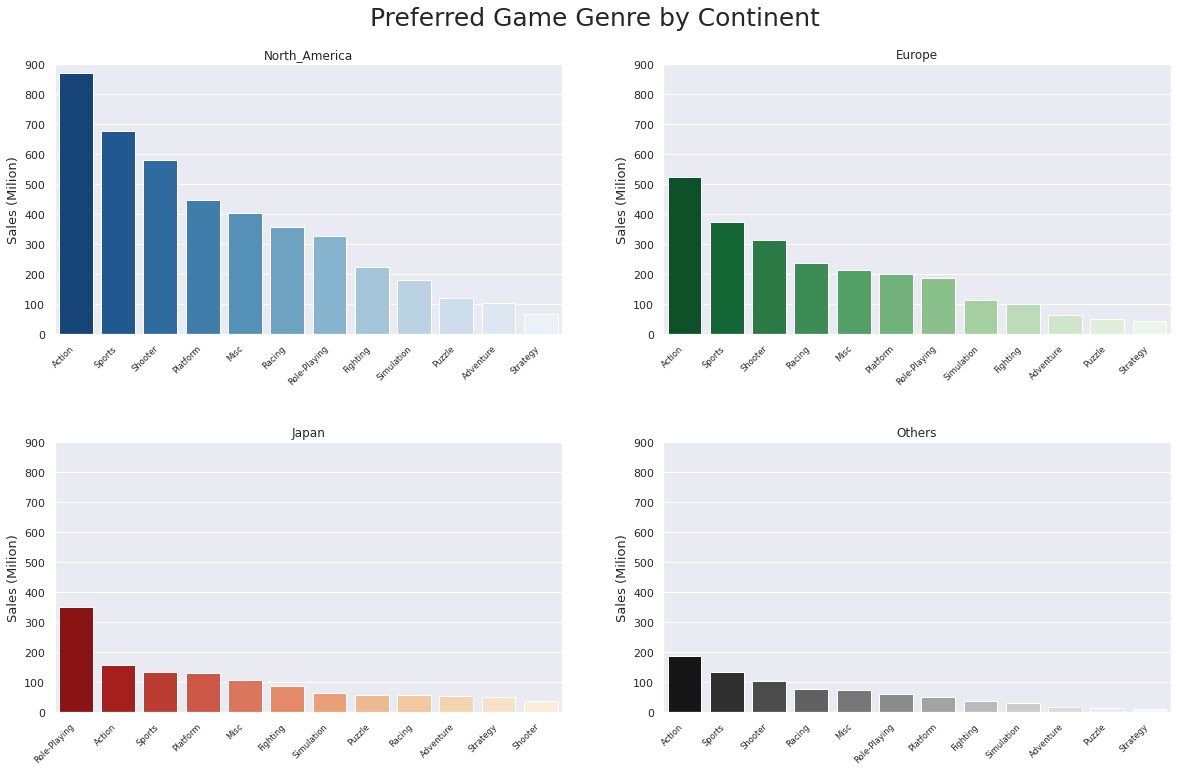

In [ ]:
# barplot으로 지역별 장르 선호도 대략적 파악
sns.set(style='darkgrid')
fig, ax = plt.subplots(2,2 , figsize=(20, 10))
fig.suptitle('Preferred Game Genre by Continent', fontsize=25)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)


NA = sns.barplot(data=gen_NA, x = 'Genre', y = 'NA_Sales', palette = "Blues_r", ax=ax1)
NA.set_xticklabels(NA.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 )
NA.set_ylim(bottom = 0, top = 900)
NA.set_title('North_America')
NA.set(xlabel=None)
NA.set_ylabel("Sales (Milion)", fontsize = 13)

EU = sns.barplot(data=gen_EU, x = 'Genre', y = 'EU_Sales', palette = "Greens_r", ax=ax2)
EU.set_xticklabels(EU.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 )
EU.set_ylim(bottom = 0, top = 900)
EU.set_title('Europe')
EU.set(xlabel=None)
EU.set_ylabel("Sales (Milion)", fontsize = 13)

JP = sns.barplot(data=gen_JP, x = 'Genre', y = 'JP_Sales', palette = "OrRd_r", ax=ax3)
JP.set_xticklabels(JP.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 )
JP.set_ylim(bottom = 0, top = 900)
JP.set_title('Japan')
JP.set(xlabel=None)
JP.set_ylabel("Sales (Milion)", fontsize = 13)


OT = sns.barplot(data=gen_Ot, x = 'Genre', y = 'Other_Sales', palette = "Greys_r", ax=ax4)
OT.set_xticklabels(OT.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 )
OT.set_ylim(bottom = 0, top = 900)
OT.set_title('Others')
OT.set(xlabel=None)
OT.set_ylabel("Sales (Milion)", fontsize = 13)

plt.show();

## 2_2 Data Analysis 2
- 연도별 게임의 트렌드가 있을까

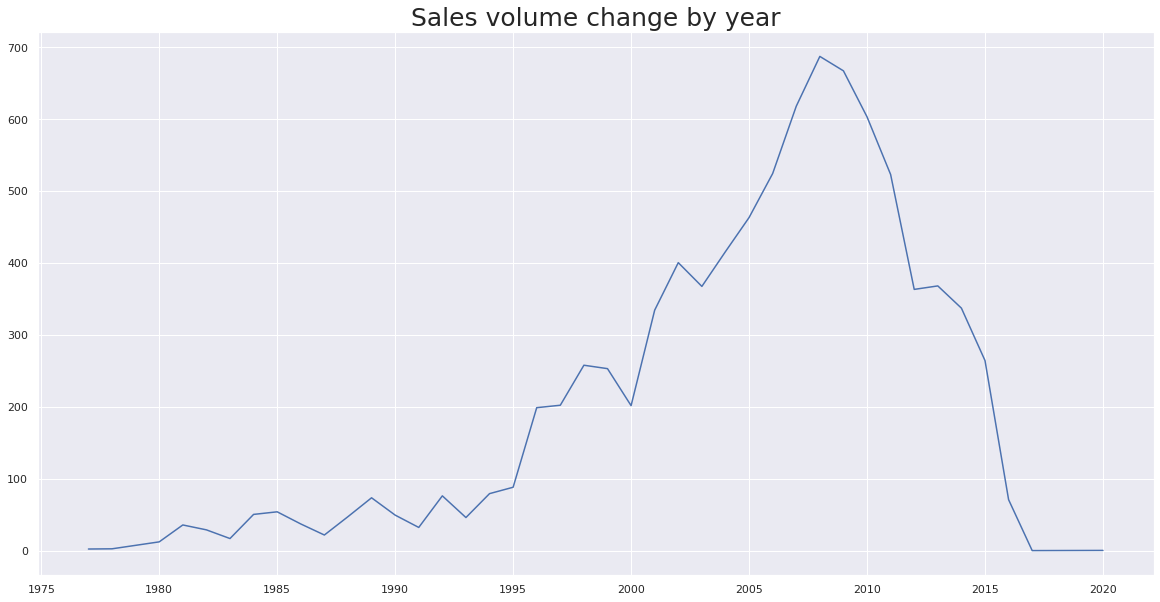

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(df1.groupby('Year')['Tot_Sales'].sum()) #연도별 비디오 게임의 총 출고량 시각화
plt.title('Sales volume change by year', size = 25)

plt.xticks(np.arange(1975,2021,5))
plt.show();

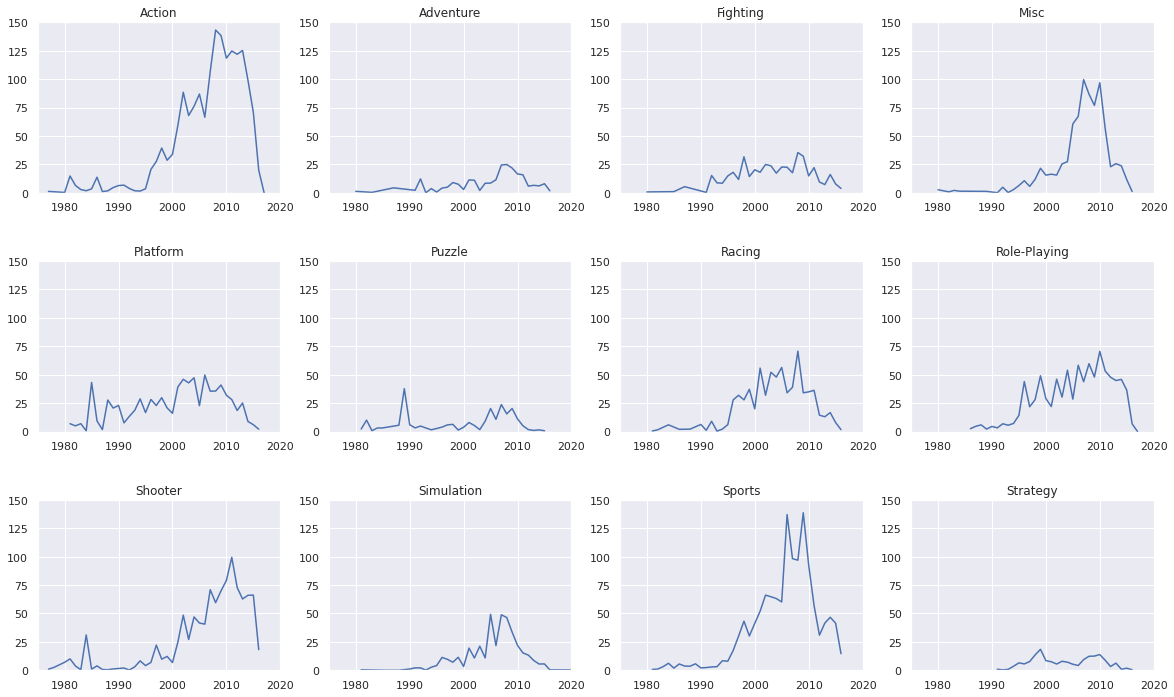

In [ ]:
gen = list(df1['Genre'].unique())
gen.sort()
fig, ax = plt.subplots(3,4, figsize=(20,10))
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)

for i, gen in enumerate(gen):
    if i <= 3:
        r = 0
    elif i > 3 and i <= 7:
        r = 1
    elif i > 7 and i <= 11:
        r = 2

    c = i % 4

    df = df1[df1['Genre'] == gen]
    df2 = df.groupby('Year')['Tot_Sales'].sum()

    ax[r,c].plot(df2)
    ax[r,c].set_title(gen)
    ax[r,c].set_ylim(0,150)
    ax[r,c].set_xlim(1975,2020)

plt.show();

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
model = ols('Tot_Sales ~ C(Year) * C(Genre)', df1).fit()

In [ ]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(Year),40.0,1015.757848,25.393946,10.877579,8.760690e-67
C(Genre),11.0,426.312347,38.755668,16.601116,4.736105e-33
C(Year):C(Genre),440.0,1531.021427,3.479594,1.490495,2.058426e-10
Residual,15920.0,37165.586839,2.334522,NaN,NaN


## 2_3 Data Analysis 3
- 출고량이 높은 게임에 대한 분석

In [ ]:
big_game = df1
big_game.index = big_game['Name']

print('모든 시기의 출고량 상위 5종목 : \n', big_game['Tot_Sales'].nlargest(5))
print('\n최근 출고량 상위 5종목 : \n', big_game[big_game['Year'] >= 2015]['Tot_Sales'].nlargest(5))

모든 시기의 출고량 상위 5종목 : 
 Name
Wii Sports                  82.74
Super Mario Bros.           40.24
Mario Kart Wii              35.83
Wii Sports Resort           33.00
Pokemon Red/Pokemon Blue    31.38
Name: Tot_Sales, dtype: float64

최근 출고량 상위 5종목 : 
 Name
Call of Duty: Black Ops 3       14.24
FIFA 16                          8.49
Star Wars Battlefront (2015)     7.67
Call of Duty: Black Ops 3        7.29
Fallout 4                        6.96
Name: Tot_Sales, dtype: float64


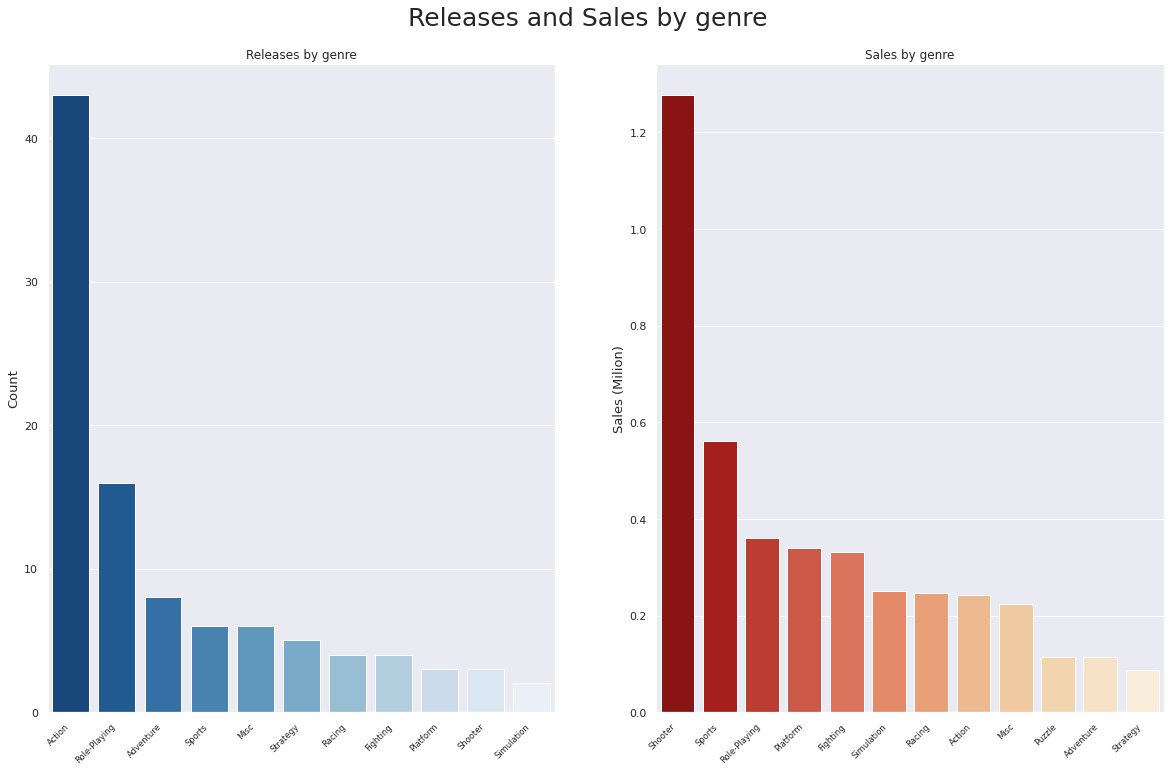

<Figure size 720x432 with 0 Axes>

In [ ]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(1,2 , figsize=(20, 10))
fig.suptitle('Releases and Sales by genre', fontsize=25)
fig.subplots_adjust(left=0.125, bottom=0., right=0.9, top=0.9, wspace=0.2, hspace=0.4)
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

resent_best = big_game[big_game['Year'] >= 2015].iloc[:100]['Genre'].value_counts()
resent_best = pd.DataFrame(resent_best)
resent_best.reset_index(inplace = True)
resent_best.columns = ['Genre', 'count']

rb = sns.barplot(data=resent_best, x = 'Genre', y = 'count', palette = "Blues_r", ax = ax1)
rb.set_xticklabels(rb.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 );
rb.set_title('Releases by genre')
rb.set(xlabel=None)
rb.set_ylabel("Count", fontsize = 13);


tot_trend = pd.DataFrame(big_game[big_game['Year']>=2015].groupby('Genre')['Tot_Sales'].mean())
tot_trend.reset_index(inplace = True)
tot_trend.sort_values('Tot_Sales', ascending = False, inplace = True)

plt.figure(figsize = (10,6))

tt = sns.barplot(data=tot_trend, x = 'Genre', y = 'Tot_Sales', palette = "OrRd_r", ax = ax2)
tt.set_xticklabels(tt.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 );

tt.set_title('Sales by genre')
tt.set(xlabel=None)
tt.set_ylabel("Sales (Milion)", fontsize = 13);

In [ ]:
#!pip install --upgrade scipy
#표본이 많으므로, 정규성을 만족한다고 가정

#등분산 test

# 귀무가설 H0 = 두 그룹은 등분산성이 있다.(분산의 차이가 없다.)
# 대립가설 H1 = 두 그룹은 등분산성이 없다.(분산의 차이가 있다.)
print(stats.levene(group1, group2).pvalue)
# 0.05보다 작으므로 두 그룹은 등분산이 아니다.

0.016564337097518044


In [ ]:
#독립 t-test, 단측검정:
p_value_t = stats.ttest_ind(group1, group2, equal_var = False, alternative = 'greater').pvalue
print(p_value_t)
#0.05보다 작으므로 두개 집단간 평균의 차이가 유의미하게 존재한다
#그래프상으로 판매율이 높은 Shooter 장르가 통계적으로도 판매율이 높다.

0.010538355067203308


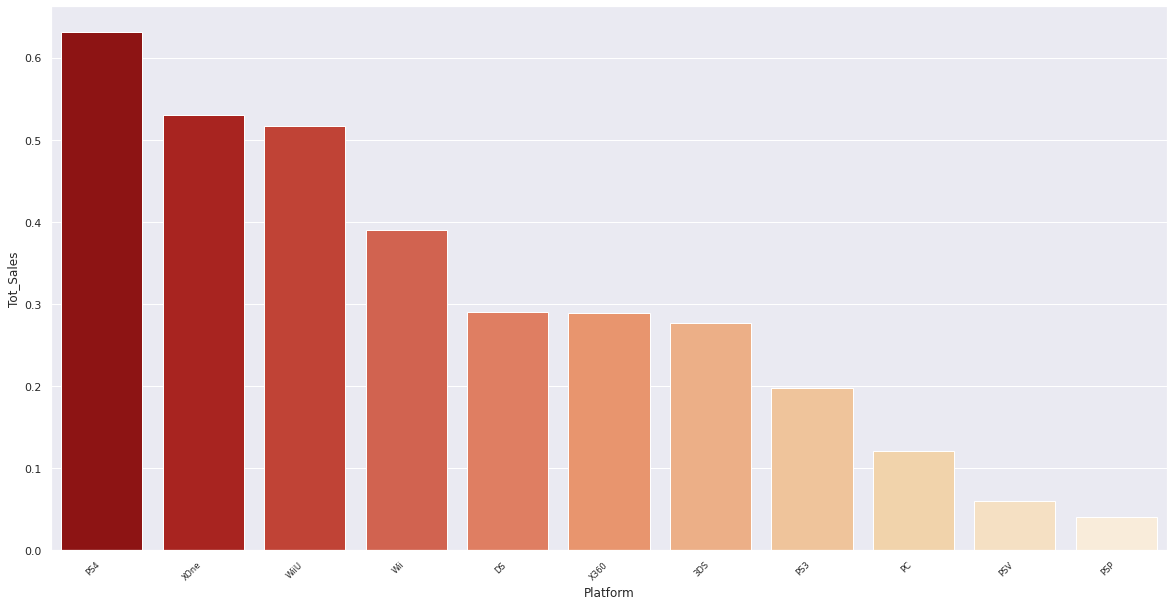

In [ ]:
#@title
Platform_total_trend = pd.DataFrame(big_game[big_game['Year']>=2015].groupby('Platform')['Tot_Sales'].mean())
Platform_total_trend.reset_index(inplace = True)
Platform_total_trend.sort_values('Tot_Sales', ascending = False, inplace = True)

plt.figure(figsize = (20,10))

Pt = sns.barplot(data = Platform_total_trend, x = 'Platform', y = 'Tot_Sales', palette = "OrRd_r")
Pt.set_xticklabels(Pt.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 );

In [ ]:
#PS4용 Shooter 게임이 얼마나 만들어지는가

PS4 = big_game[big_game['Platform']=='PS4']

PS4['Genre'].value_counts()

Action          122
Role-Playing     47
Sports           43
Shooter          34
Adventure        19
Racing           17
Fighting         17
Misc             15
Platform         11
Simulation        5
Strategy          5
Puzzle            1
Name: Genre, dtype: int64

In [ ]:
#PS4용 Shooter게임이 잘 팔리는가
PS4.groupby('Genre')['Tot_Sales'].sum().sort_values(ascending=False)

Genre
Action          87.08
Shooter         75.32
Sports          50.10
Role-Playing    25.78
Racing          11.57
Fighting         8.04
Misc             7.37
Platform         6.99
Adventure        4.70
Simulation       0.77
Strategy         0.42
Puzzle           0.02
Name: Tot_Sales, dtype: float64

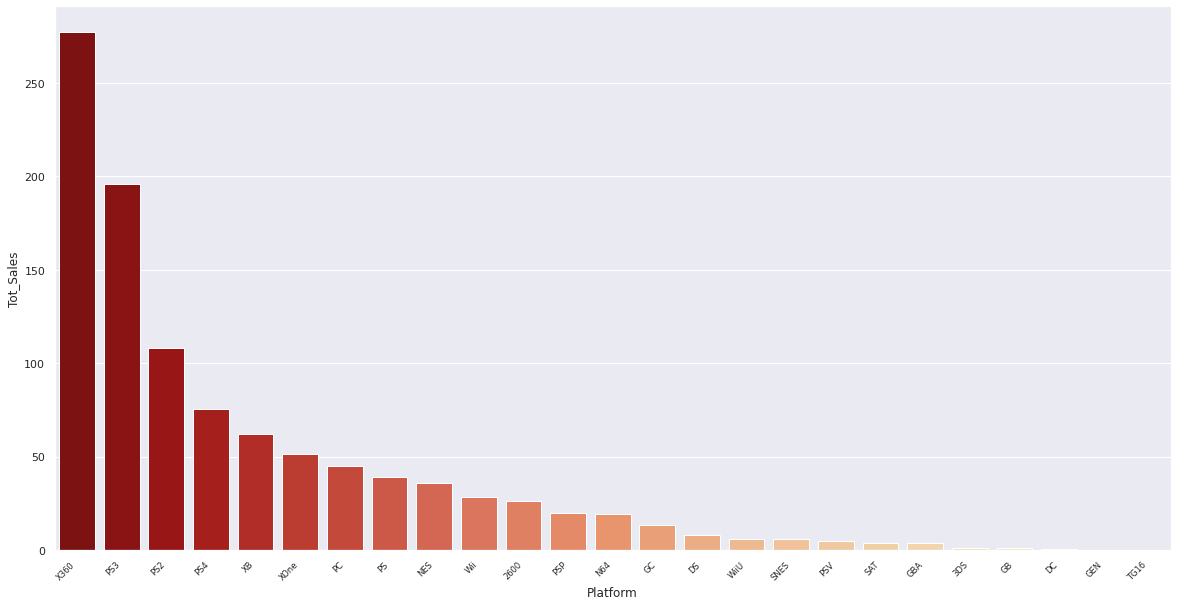

In [ ]:
# shooter Genre 판매량이 좋은 Platform
shooter_platform = pd.DataFrame(big_game[big_game['Genre'] == 'Shooter'].groupby('Platform')['Tot_Sales'].sum().sort_values(ascending=False))
shooter_platform.reset_index(inplace = True)

plt.figure(figsize = (20,10))

sp = sns.barplot(data = shooter_platform, x = 'Platform', y = 'Tot_Sales', palette = "OrRd_r")
sp.set_xticklabels(sp.get_xticklabels(), rotation=45,
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-small'
                 );